# Plotting Results trying out different libraries

In [2]:
from sc import DDSC
from __future__ import division
import numpy as np
import pandas as pd
import pickle

############ plotting
import matplotlib.pyplot as plt
plt.style.use('ggplot')
## plotting basis functions
import matplotlib.cm as cm
# plotly
import plotly.plotly as py
from plotly.graph_objs import *
###############################
# plots directory
figure_directory= '../../../doc/thesis/figures/'
# change so that all figures have font size defulat as 22
plt.rcParams.update({'font.size': 18})
# figure size always the same
plt.figure(figsize=(16,12))
# --- Locally installed modules -----------------------------------------
from pandasreader import Reader

/usr/local/lib/python2.7/site-packages/librosa/core.py:26: UserWarning: Could not import scikits.samplerate. Falling back to scipy.signal
  'Falling back to scipy.signal')


In [3]:
#   read dataset
data = 1
dataset = ['cleanpecanhour2014','weekendpecanhour2014','weekdayspecanhour2014']
reader = Reader(dataset[data])
######################################
#returning a datafile pandasObject
df = reader.dataParser()
#
print "parsed the data"
## returns a dictionary of all of the appliances
d = reader.format_data(df)
#    print "formated data"
## Save a dictionary into a pickle file.
#    pickle.dump( d, open( "d.p", "wb" ) )
#
######################################
# Load the dictionary back from the pickle file.
#d = pickle.load( open( "d.p", "rb" ) )
# load the dictionary WITHOUT other
#d = pickle.load( open( "do.p", "rb" ) )

../../../res/datasets ['Energimyndighet data'] ['.DS_Store', '.testhouses2012.csv.swp', 'cleanpecanhour2014.csv', 'db.sql', 'grepScript.sh', 'minutes2014.sql', 'pecanhour2014.csv', 'weekdayspecanhour2014.csv', 'weekendpecanhour2014.csv']
parsed the data


In [4]:
# %load sc.py
#!/usr/bin/env python2.7
'''
Program to train disaggregation using Sparse Coding
'''
factor_n_t = 5 # heuristically determined

timeframes = [14,30,60]
timeframes = [48]
#timeframes = [x*24 for x in timeframes]
alphas = [0.0001]
#alphas = [0.0001, 0.00001, 0.000001]
portion = 0.5
# Good values (t,n,alpha)
# (14,40, alpha = 0.0001)
# (336,800, alpha = 0.00001)
# (720,,1400, alpha = )
for timeframe, alpha in zip(timeframes,alphas):
    n = int(factor_n_t*timeframe)
    x_train, x_test = reader.split(d,portion,timeframe,portion_houses=0.1)
# use in whole house disaggregation step
    x_train_use = x_train.pop('use',None)
    x_test_use = x_test.pop('use',None)
    x_train_localhour = x_train.pop('localhour',None)
    x_test_localhour = x_test.pop('localhour',None)


# algorithm starts

    # parameters
    train_set = x_train
    test_set = x_test
    train_sum = sum(x_train.values())
    k = len(x_train.keys())
    T,m = x_train[x_train.keys()[0]].shape
    rp = 0.0005
    epsilon = 0.001
    alpha = 0.0001
    steps = 100 # steps must be higher than k
    # get data
    n_components = n

    # Sparse Coding pre_training
    sc = DDSC(train_set,train_sum,alpha,epsilon,rp,steps,n_components,m,T,k)
    print "started the pre-training"
    A_list,B_list = sc.pre_training(x_train.values())
    print "done pre_training"
    # Discriminative Disaggregation training
    B_cat = sc.DD(x_train_use.values,B_list,A_list)
    print "done DD"
    # Given test examples x_test
    A_prime = sc.F(x_test_use.values,B_cat,A=np.vstack(A_list))
    A_last = np.split(A_prime,k,axis=0)
    x_predict = sc.predict(A_last,B_list)
    x_predict_sum = sum(x_predict)
    print "the shape of the first predicted appliances is :%s" %(x_predict[0].shape,)
    # energy disaggregation accuracy
    acc = sc.accuracy(x_train.values(),train_sum,B_list,A_last)
    # energy disaggregation error
    error, error_star = sc.error(x_train.values(),train_sum,B_list,A_list)
    print "error: %s, error_star: %s" % (sum(error),sum(error_star))
    acc_nnsc, acc_ddsc = sc.get_accuracy_plot()
    err_nnsc, err_ddsc = sc.get_error_plot()
    # plotting acc/err
    a_nnsc, a_ddsc = sc.get_a()
    b_nnsc, b_ddsc = sc.get_b()

started the pre-training
NNSC change is 50.8050859676 for iter 1, and B change is 0.375708516483
NNSC change is 0.046000519447 for iter 2, and B change is 1.42968604016e-05
NNSC change is 0.0477773828967 for iter 3, and B change is 1.42849796621e-05
NNSC change is 0.0500078333825 for iter 4, and B change is 1.45313189762e-05
NNSC change is 0.0529144028065 for iter 5, and B change is 1.49679392816e-05
NNSC change is 0.0562873350935 for iter 6, and B change is 1.55954553432e-05
NNSC change is 0.0598153672695 for iter 7, and B change is 1.64026837396e-05
NNSC change is 0.0631221445967 for iter 8, and B change is 1.73892704845e-05
NNSC change is 0.0658322854832 for iter 9, and B change is 1.85332022909e-05
NNSC change is 0.0676466440648 for iter 10, and B change is 1.98091889906e-05
NNSC change is 0.06839704386 for iter 11, and B change is 2.11776224514e-05
NNSC change is 0.0680635533723 for iter 12, and B change is 2.25966164056e-05
NNSC change is 0.0667545986462 for iter 13, and B change

/usr/local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations



## Using matplotlib

### Importing plotly to be able to be used

In [15]:
print sum(x_predict)[0:,1]
print "B_list: ",np.linalg.norm(sum(B_list)), "A_last: ", np.linalg.norm(sum(A_last)), "A_list: ", np.linalg.norm(sum(A_list))

[ 24.7668406   27.16791059  59.17923003  13.21471168  14.30442482
  14.51170518  42.61508269]
B_list:  5.06334535646 A_last:  2147.6933162 A_list:  81.1594752664


In [26]:
print x_test.keys()
x_train.keys()

['refrigerator1', 'dishwasher1', 'furnace1', 'air1']


['refrigerator1', 'dishwasher1', 'furnace1', 'air1']

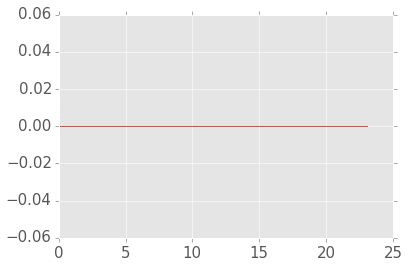

In [22]:
plt.plot(np.asarray(x_predict[1])[0:,0])

In [5]:
#x_predict = sc.predict(A_last,B_list)
x_predict = sc.predict(A_list,B_list)

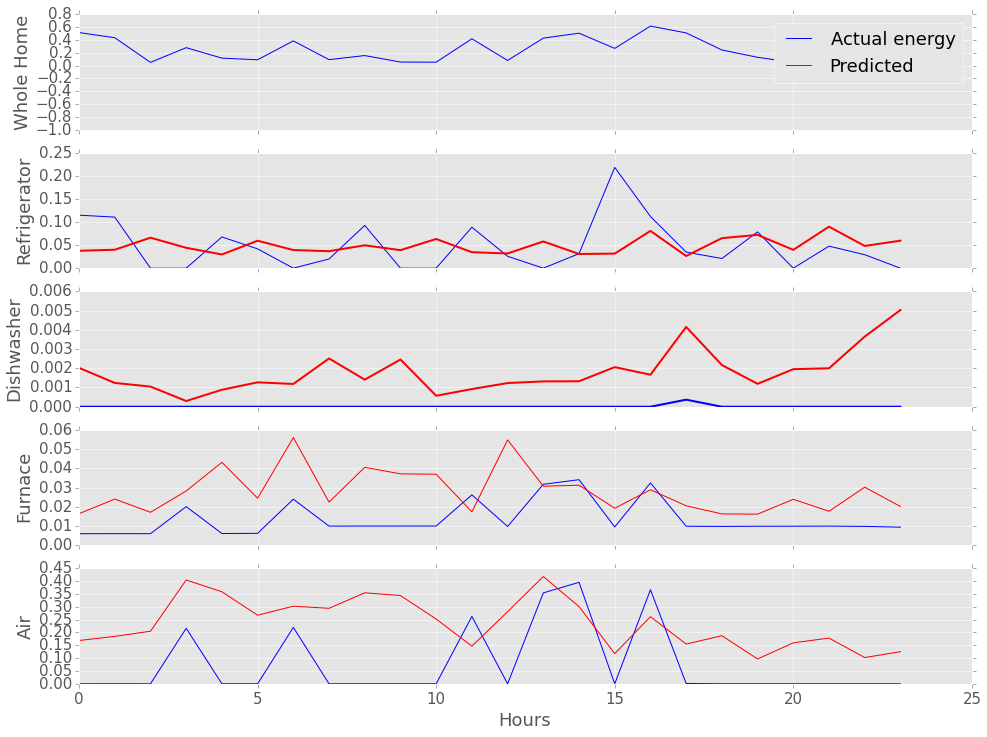

In [12]:
# row and column sharing
house = 0
f, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(5, 1, sharex='col', sharey='row', figsize=(16,12))
x = range(x_train[x_train.keys()[0]].shape[0])
plt.rcParams.update({'font.size': 15})

y = np.asarray(x_test_use)[0:,house]
ax1.plot(x, y, color='b',label='Actual energy')
y=[-1]*x_train[x_train.keys()[0]].shape[0]
ax1.plot(x, y, color='r', label='Predicted')
#ax1.set_ylim([0,2])
ax1.set_ylabel('Whole Home')
ax1.legend()
##
y = np.asarray(x_test[x_test.keys()[0]])[0:,house]
ax2.plot(x, y, color='b')
y = np.asarray(x_predict[0])[0:,house]
ax2.plot(x , y, color='r', linewidth=2)
#ax2.get_yaxis().set_visible(False)
ax2.set_ylabel('Refrigerator')
#ax2.set_ylim(-0.01)
##
y = np.asarray(x_test[x_test.keys()[1]])[0:,house]
ax3.plot(x, y, color='b', linewidth=2)
y = np.asarray(x_predict[1])[0:,house]
ax3.plot(x,y, color='r', linewidth=2)
#ax3.get_yaxis().set_visible(False)
ax3.set_ylabel('Dishwasher')
#ax3.set_ylim(-0.00001)

##
y = np.asarray(x_test[x_test.keys()[2]])[0:,house]
ax4.plot(x, y, color='b')
y = np.asarray(x_predict[2])[0:,house]
ax4.plot(x,y, color='r')
#ax4.get_yaxis().set_visible(False)
ax4.set_ylabel('Furnace')

##
y = np.asarray(x_test[x_test.keys()[3]])[0:,house]
ax5.plot(x, y, color='b')
y = np.asarray(x_predict[3])[0:,house]
ax5.plot(x,y, color='r')
#ax5.get_yaxis().set_visible(False)
ax5.set_ylabel('Air')
ax5.set_xlabel('Hours')
f.savefig(figure_directory+'lol_end_250_24')

## row and column sharing
f, ((ax1, ax2, ax3, ax4, ax5, ax6)) = plt.subplots(6, 1, sharex='col', sharey='row', figsize=(16,18))
## piechart
f2, ((axes1, axes2)) = plt.subplots(2, 1, sharex='col', sharey='row', figsize=(16,18))
pie_chart_true = []
pie_chart_pred = []

x = range(x_train[x_train.keys()[0]].shape[0])
plt.rcParams.update({'font.size': 15})

y = np.asarray(x_test_use)[0:,0]
ax1.plot(x, y, color='b',label='Actual energy')
y=[-1]*x_train[x_train.keys()[0]].shape[0]
ax1.plot(x, y, color='r', label='Predicted')
#ax1.set_ylim([0,2])
ax1.set_ylabel('Whole Home')
ax1.legend()
##
y = np.asarray(x_test[x_test.keys()[0]])[0:,0]
pie_chart_true.append(y.sum())
ax2.plot(x, y, color='b')
y = np.asarray(x_predict[0])[0:,0]
ax2.plot(x , y, color='r')
#ax2.get_yaxis().set_visible(False)
ax2.set_ylabel('Refrigerator')
pie_chart_pred.append(y.sum())
##
y = np.asarray(x_test[x_test.keys()[1]])[0:,0]
pie_chart_true.append(y.sum())
ax3.plot(x, y, color='b')
y = np.asarray(x_predict[1])[0:,0]
ax3.plot(x,y, color='r')
#ax3.get_yaxis().set_visible(False)
ax3.set_ylabel('Dishwasher')
pie_chart_pred.append(y.sum())

##
y = np.asarray(x_test[x_test.keys()[2]])[0:,0]
pie_chart_true.append(y.sum())
ax4.plot(x, y, color='b')
y = np.asarray(x_predict[2])[0:,0]
ax4.plot(x,y, color='r')
#ax4.get_yaxis().set_visible(False)
ax4.set_ylabel('Furnace')
pie_chart_pred.append(y.sum())

##
y = np.asarray(x_test[x_test.keys()[3]])[0:,0]
pie_chart_true.append(y.sum())
ax5.plot(x, y, color='b')
y = np.asarray(x_predict[3])[0:,0]
ax5.plot(x,y, color='r')
#ax5.get_yaxis().set_visible(False)
ax5.set_ylabel('Air')
pie_chart_pred.append(y.sum())
##
y = np.asarray(x_test[x_test.keys()[4]])[0:,0]
pie_chart_true.append(y.sum())
ax6.plot(x, y, color='b')
y = np.asarray(x_predict[4])[0:,0]
ax6.plot(x,y, color='r')
#ax6.get_yaxis().set_visible(False)
ax6.set_ylabel('Others')
ax6.set_xlabel('Hours')
pie_chart_pred.append(y.sum())



def pie_chart(self, subplot, pie_chart, labels):
    # The slices will be ordered and plotted counter-clockwise.
    ## --- Plotting the true-piechart
    pie_chart_sum = sum(pie_chart)
    pie_chart = map(lambda x: x/pie_chart_sum,pie_chart)
    cmap = plt.cm.prism
    colors = cmap(np.linspace(0., 1., len(pie_chart)))
    pie_wedge_collection = subplot.pie(pie_chart, colors=colors, labels=labels, labeldistance=1.05);

    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
    # Set aspect ratio to be equal so that pie is drawn as a circle.

labels = x_test.keys()
pie_chart(axes1,pie_chart_true,labels)
axes1.set_title('True usage')
pie_chart(axes2,pie_chart_pred,labels)
axes2.set_title('Predicted usage')
axes2.text(0.95, 0.01, 'Accuracy of ' + str(round(self.acc[0],1)),
verticalalignment='center', horizontalalignment='right',
transform=axes2.transAxes,
color='black', fontsize=45)

# Using data to get the right accuracy, error into plotly

In [5]:
acc_ddsc

[(0.11180314331250371, 0.99999999999999956),
 (0.11180314331250371, 0.99999999999999956),
 (0.11180314331250371, 0.99999999999999956),
 (0.11180314331250371, 0.99999999999999956),
 (0.11180314331250371, 0.99999999999999956),
 (0.11180314331250371, 0.99999999999999956),
 (0.11180314331250371, 0.99999999999999956),
 (0.11180314331250371, 0.99999999999999956),
 (0.11180314331250371, 0.99999999999999956),
 (0.11180314331250371, 0.99999999999999956),
 (0.11180314331250371, 0.99999999999999956),
 (0.11180314331250371, 0.99999999999999956),
 (0.11180314331250371, 0.99999999999999956),
 (0.11180314331250371, 0.99999999999999956),
 (0.11180314331250371, 0.99999999999999956),
 (0.11180314331250371, 0.99999999999999956),
 (0.11180314331250371, 0.99999999999999956),
 (0.11180314331250371, 0.99999999999999956),
 (0.11180314331250371, 0.99999999999999956),
 (0.11180314331250371, 0.99999999999999956),
 (0.11180314331250371, 0.99999999999999956),
 (0.11180314331250371, 0.99999999999999956),
 (0.111803

In [6]:
acc_nnsc#,acc_ddsc

[(0.11180314331250371, 0.8128273277548641)]

In [15]:
err_plot = map(lambda x: sum(err_nnsc[x][1]),range(steps+1))
acc_plot = map(lambda x: acc_nnsc[x][0],range(steps+1))

IndexError: list index out of range

In [44]:
Accuracy = Scatter(
    x=range(1,steps+1),
    y=acc_plot
    
)
Error = Scatter(
    x=range(1,steps+1),
    y=err_plot
    
)
data = Data([Accuracy,Error])

py.iplot(data, filename = 'acc_err_nnsc')

In [36]:
fig = py.get_figure("https://plot.ly/~eleijonmarck/80/")

In [39]:
py.plot(fig)

u'https://plot.ly/~eleijonmarck/111'

## Plotting the B matrices (basis functions)

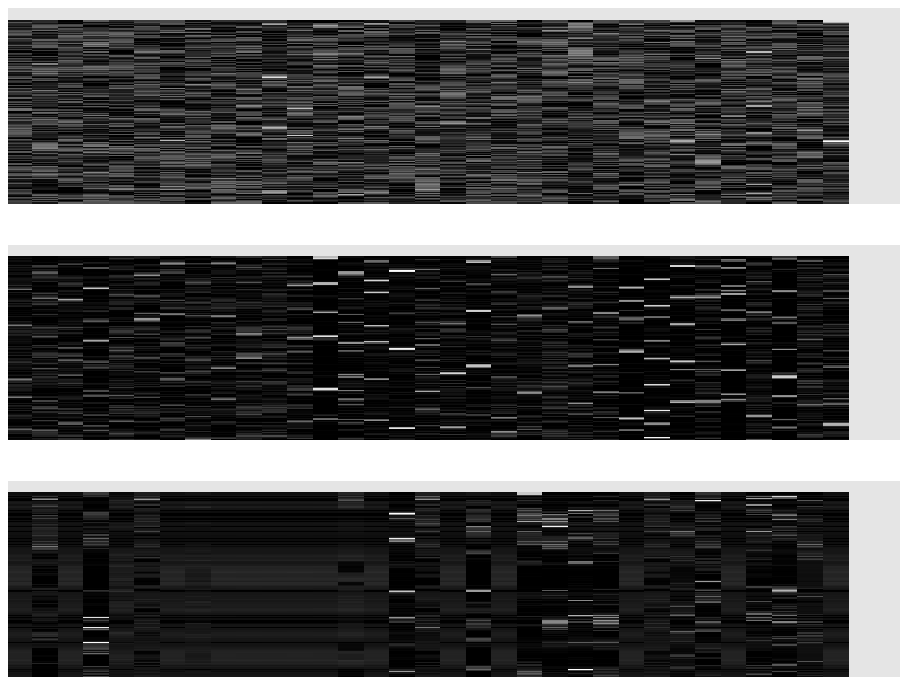

In [4]:
plt.figure(figsize=(16,12))

# row and column sharing
f, ((ax1, ax2, ax3)) = plt.subplots(3, 1, sharex='col', sharey='row', figsize=(16,12))
plt.rcParams.update({'font.size': 15})


B_list[0] = B_list[0]/np.sum(B_list[0],axis=1)[:,None]  # Normalize
ax1.pcolor(B_list[0], cmap = cm.Greys_r)
B_list[1] = B_list[1]/np.sum(B_list[1],axis=1)[:,None]  # Normalize
ax2.pcolor(B_list[1], cmap = cm.Greys_r)
B_list[2] = B_list[2]/np.sum(B_list[2],axis=1)[:,None]  # Normalize
ax3.pcolor(B_list[2], cmap = cm.Greys_r)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

plt.savefig(figure_directory+'basis')

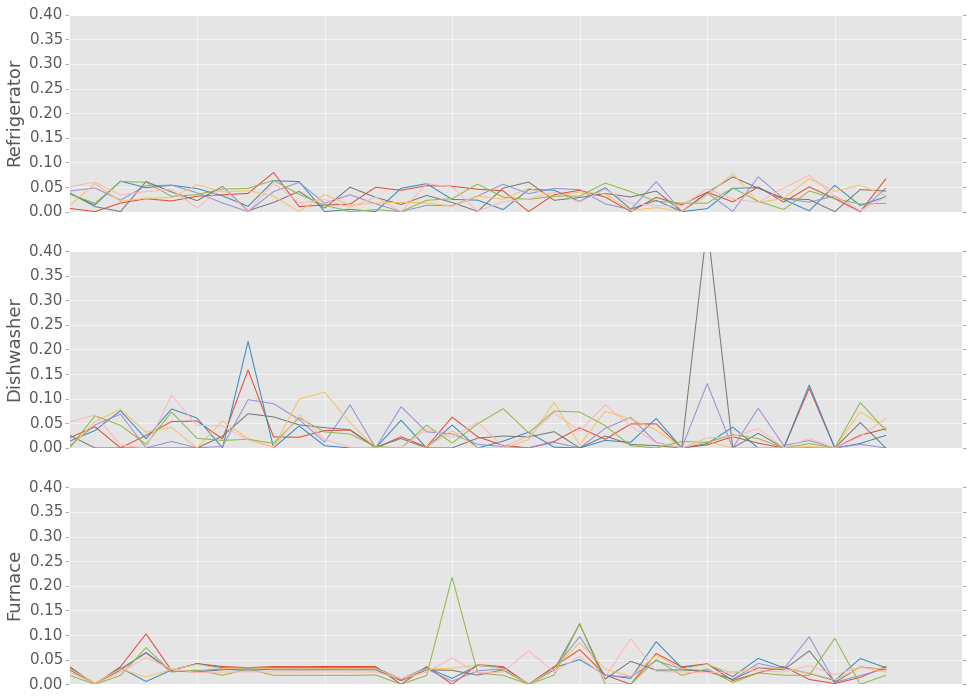

In [21]:
# row and column sharing
f, ((ax1, ax2, ax3)) = plt.subplots(3, 1, sharex='col', sharey='row', figsize=(16,12))
plt.rcParams.update({'font.size': 15})


for base in range(7):
    ax1.plot(range(n),B_list[0][base,0:])
    ax2.plot(range(n),B_list[1][base,0:])
    ax3.plot(range(n),B_list[2][base,0:])

ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
ax1.set_ylim([0,0.4])
ax1.set_ylabel('Refrigerator')
ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
ax2.set_ylim([0,0.4])
ax2.set_ylabel('Dishwasher')
ax3.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
ax3.set_ylim([0,0.4])
ax3.set_ylabel('Furnace')


plt.savefig(figure_directory+'app_basis')

## Plottting the matrix norm of A and B for NNSC and DDSC

In [18]:
b_ddsc

[0.92040254719820247,
 0.92066486253253066,
 0.92209332216630147,
 0.92246141012320182,
 0.92370930793202932,
 0.92503867745324386,
 0.92619636715243692,
 0.92787109497799491,
 0.92986836127582895,
 0.92985822257635542,
 0.93149994100676248,
 0.93333500705695693,
 0.9348384114167323,
 0.9367877587556207,
 0.93742003114850081,
 0.93933159417523526,
 0.94149071325313904,
 0.94250066247973285,
 0.94506716969577831,
 0.95279684893434213,
 0.94727433522333915,
 0.94809583726443725,
 0.94908383619184422,
 0.95007599663297815,
 0.95320041650758891,
 0.95579556938799648,
 0.95769286398008668,
 0.9662536953046853,
 0.96187824235745811,
 0.97072518601366931,
 0.96477850953555089,
 0.97640963483692822,
 0.96875241845982307,
 0.97225636873651067,
 0.97676226654136444,
 0.97764614689792273,
 0.9787144891398063,
 0.981889538388933,
 0.9834549110101084,
 0.98499045325220969,
 0.98485569421424735,
 0.98870988394744397,
 0.99208949810275215,
 0.99400388462013467,
 1.0048637449747391,
 1.000054523061250

In [19]:
Activation = Scatter(
    x=range(1,steps+1),
    y=a_ddsc
    
)
Basis = Scatter(
    x=range(1,steps+1),
    y=b_ddsc
    
)
data = Data([Activation,Basis])

py.iplot(data, filename = 'a_b_ddsc')